In [1]:
# !pip install --upgrade tensorflow
# !pip install -q tensorflow-probability
# !pip install tensorflow-probability[tf]
# !pip install tensorflow-io

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow_io as tfio

2024-03-23 16:15:42.531605: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 16:15:42.574708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hailea/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/hailea/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/hailea/.local/lib/python3.10/site-packag

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [4]:
def get_encoder(latent_dim=64):
    encoder_inputs = keras.Input(shape=(144, 256, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=64):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
def get_vqvae(latent_dim=64, num_embeddings=512):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(144, 256, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

2024-03-23 16:15:55.968852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5


Model: "vq_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 144, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 36, 64, 64)     │        22,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vector_quantizer                │ (None, 36, 64, 64)     │             0 │
│ (VectorQuantizer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 144, 256, 1)    │        55,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,657 (307.25 KB)

 Trainable params: 78,657 (307.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [7]:
def load_video_frames(video_path, target_size=(256, 144)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(gray_frame, target_size)
        frames.append(resized_frame)
    cap.release()
    return np.array(frames)

def load_data_from_directory(directory):
    all_frames = []
    for filename in os.listdir(directory):
        if filename.endswith((".mp4", ".avi")):  # Add more video formats if needed
            video_path = os.path.join(directory, filename)
            frames = load_video_frames(video_path)
            all_frames.append(frames)
    all_frames = np.concatenate(all_frames, axis=0)
    return all_frames

def preprocess_frames(frames):
    frames_expanded = np.expand_dims(frames, -1)
    frames_scaled = (frames_expanded / 255.0) - 0.5
    return frames_scaled

In [10]:
directory = "/data/ai_club/team_13_2023-24/videos/train/test_video"
all_frames = load_data_from_directory(directory)
all_frames_preprocessed = preprocess_frames(all_frames)

x_train, x_test = train_test_split(all_frames_preprocessed, test_size=0.2, random_state=42)

data_variance = np.var(x_train / 255.0)

In [12]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30


I0000 00:00:1711225129.630189  980295 service.cc:145] XLA service 0x7f3abc01ee70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711225129.630240  980295 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-23 16:18:49.795348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-23 16:18:50.119771: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8901
2024-03-23 16:18:52.919520: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 16:18:52.919558: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_

 1/77 ━━━━━━━━━━━━━━━━━━━━ 19:59 16s/step - loss: 71505.4219 - reconstruction_loss: 71505.4219 - vqvae_loss: 8.9208e-04

I0000 00:00:1711225144.052384  980295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 43695.1133 - reconstruction_loss: 43692.8086 - vqvae_loss: 2.2942

2024-03-23 16:19:16.737932: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 16:19:16.737993: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 194ms/step - loss: 43521.6875 - reconstruction_loss: 43349.9961 - vqvae_loss: 2.5035 - total_loss: 30341.5625 - vq_loss: 18.4129
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 24906.1230 - reconstruction_loss: 22866.2012 - vqvae_loss: 2039.5287 - total_loss: 30220.7598 - vq_loss: 7384.8848
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 117579.9375 - reconstruction_loss: 22570.9258 - vqvae_loss: 95010.8906 - total_loss: 230034.8906 - vq_loss: 207318.8125
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - loss: 1151755.6250 - reconstruction_loss: 22886.2012 - vqvae_loss: 1128866.1250 - total_loss: 1934770.8750 - vq_loss: 1912136.2500
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - loss: 6702399.5000 - reconstruction_loss: 22601.6074 - vqvae_loss: 6679800.5000 - total_loss: 9962105.0000 - vq_loss: 9939265.0000
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 25603748.0000 - reconstruction_loss: 22540.3125 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


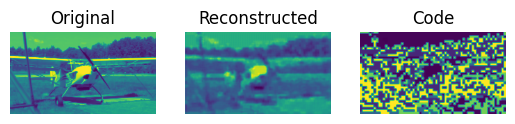

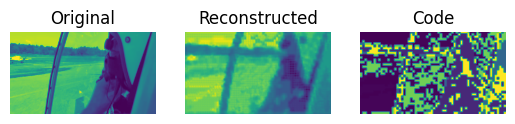

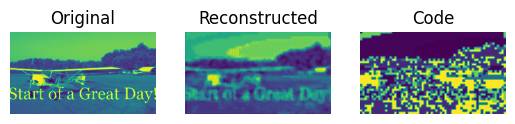

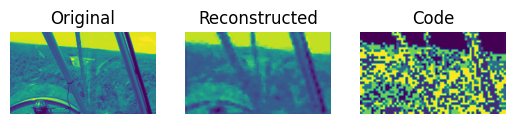

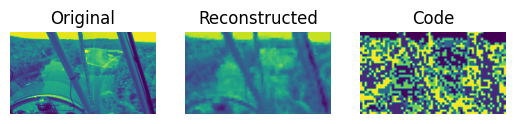

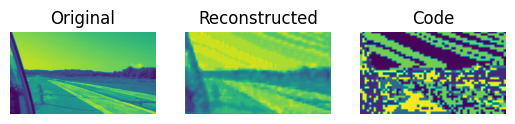

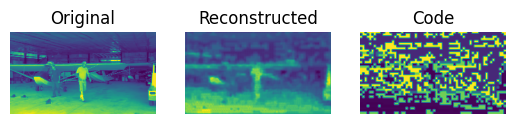

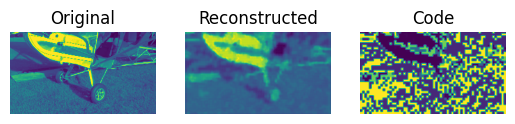

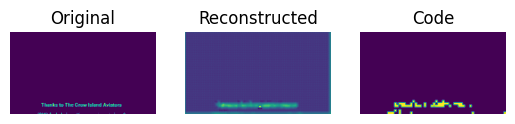

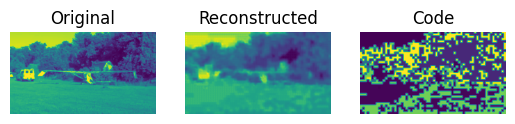

In [41]:
def show_subplot(original, reconstructed, codebook):
    plt.subplot(1, 3, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(codebook)
    plt.title("Code")
    plt.axis("off")

    plt.show()
    
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test), 10)
test_images = x_test[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)
    
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructions_test[i].squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


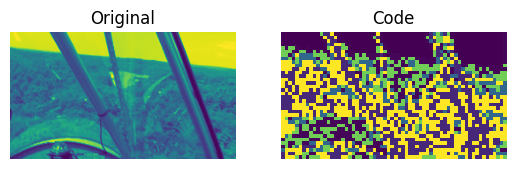

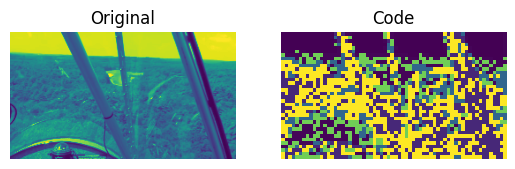

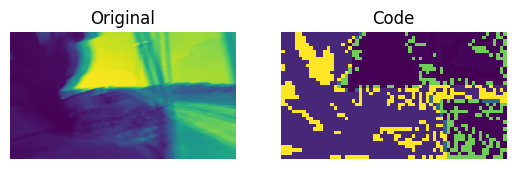

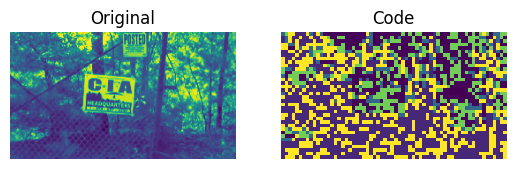

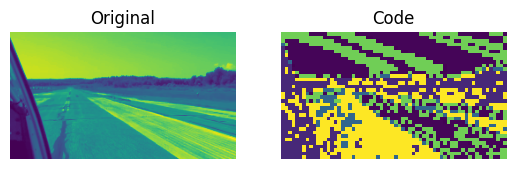

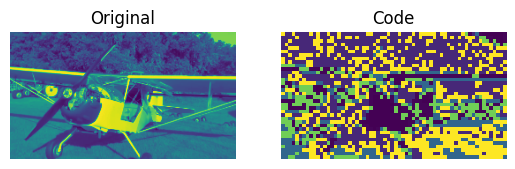

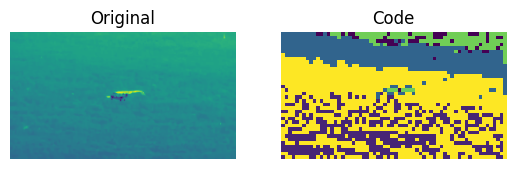

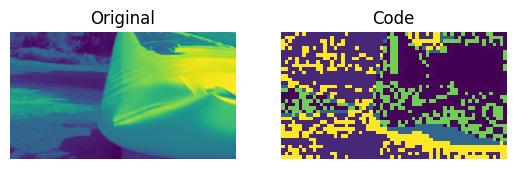

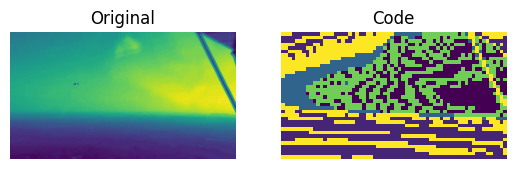

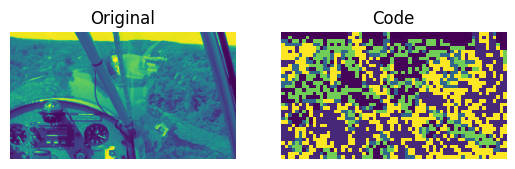

In [15]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()